# Tiles processing: Counting nulcei example

In this notebook we will process a big dataset that has been saved in `zarr` format to count cells in individual tiles. For every tile, we will write a pixel in an output image. Hence, we are producing a cell-count image that is smaller than the original image by a factor that corresponds to the tile size.

In [1]:
import skimage
import zarr

import pyclesperanto as cle
import numpy as np
import dask.array as da

from skimage import io, filters, measure, morphology
from numcodecs import Blosc

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed License: CC-BY 4.0. We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format online.

In [2]:
image = io.imread("https://github.com/haesleinhuepf/BioImageAnalysisNotebooks/raw/refs/heads/main/data/P1_H_C3H_M004_17-cropped.tif")[1]

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## Loading the zarr-backed image
Dask brings built-in support for the zarr file format. We can create dask arrays directly from a zarr file.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

/home/strigaud/Libraries/miniforge3/envs/proto/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

We can apply image processing to this tiled dataset directly.

## Counting nuclei

For counting the nuclei, we setup a simple image processing workflow that applies Voronoi-Otsu-Labeling to the dataset. Afterwards, we count the segmented objects. As nuclei might be counted twice which touch the tile border, we have to correct the count for every tile. Technically, we could remove the objects which touch one of the vertical or horizontal tile borders. However, there is a simpler way for correcting for this error: We count the number of nuclei after segmentation. Then, we remove all nuclei which touch any image border and count the remaining nuclei again. We can then assume that half of the removed nuclei should be counted. Hence, we add the two counts, before and after edge-removal, and compute the average of these two measurements. Especially on large tiles with many nuclei, the remaining error should be negligible. 

> __WARNING:__ It is not recommended to apply such an estimating cell counting method when each tile contains only few nuclei.

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    print("Processing image of size", image.shape)
    
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    nuclei_count = labels.max()
    
    # Count nuclei excluding those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    print(result.shape)
    
    return result

[Issues](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163) can happen because of asynchronous processing of the GPU, deactivating it is an option if you are facing them.

In [5]:
cle.wait_for_kernel_to_finish(True)

This time, we do not use tile overlap, because we are not measuring properties of the nuclei and thus, don’t need a prefect segmentation of them.

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)
tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead


dask.array<count_nuclei, shape=(500, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

As the result image is much smaller then the original, we can compute the whole result map.

In [7]:
result = tile_map.compute()

Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead


Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
(1, 1)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
(1, 1)


Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_max

(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)


Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead


(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)


Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead
Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead


In [8]:
result.shape

(5, 5)

Again, as the result map is small, we can just visualize it.

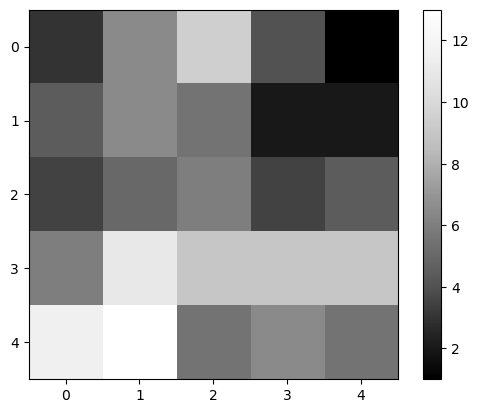

In [9]:
cle.imshow(result, colorbar=True)

With a quick visual check in the original image, we can see that indeed in the bottom left corner of the image, there are more cells than in the top right.

Deprecated: this function is deprecated, use detect_maxima instead
Deprecated: Please use mean() instead


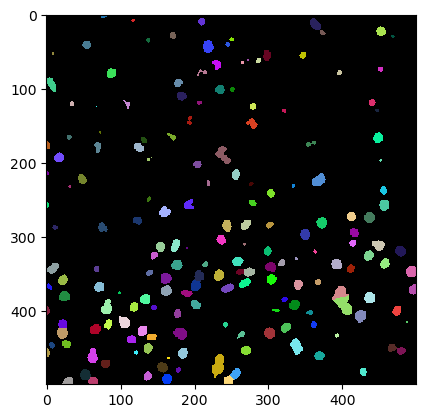

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)

### Acknowledgement

This notebook is adapted from of the [BioImageAnalysisNotebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks) of Robert Haase ([10.5281/zenodo.10465773](https://zenodo.org/badge/latestdoi/449194300)).